In [2]:
!pip install pandas matplotlib seaborn numpy notebook replicate langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00


In [3]:
# Langkah 1. SET UP Lingkungan

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import notebook
from langchain_community.llms import Replicate
import time
from google.colab import drive
from google.colab import userdata
import os

In [4]:
# Mounting Google drive
try:
  drive.mount('/content/drive')
  print("Google Drive berhasil terhubung")
except Exception as e:
  print(f"Gagal Menghubungkan google drive: {e}")

# API_Token Configuration
# Masukkan api_token dari google colab
api_token = userdata.get("api_token")
# Masukkan tabel ke environment variable
os.environ["REPLICATE_API_TOKEN"] = api_token



Mounted at /content/drive
Google Drive berhasil terhubung


Dataset Berhasil Dimuat...


   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationsh

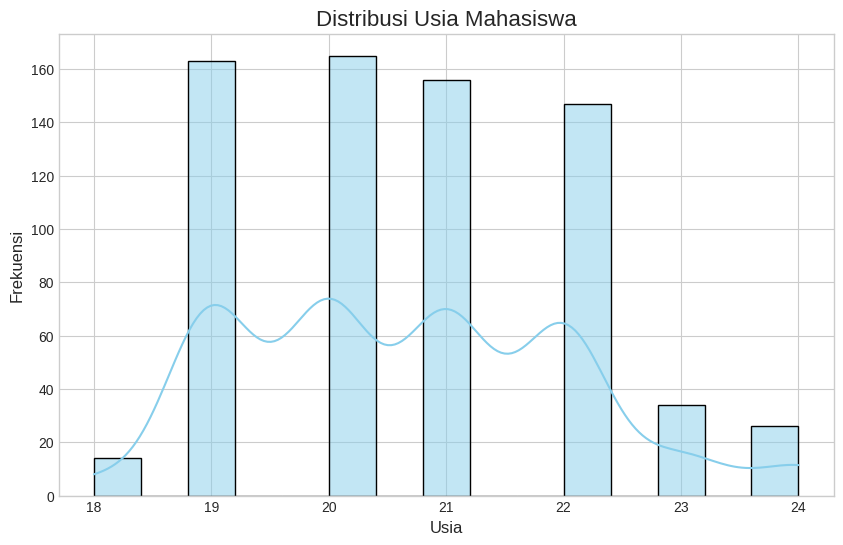


Kolom untuk waktu ditemukan: 'Avg_Daily_Usage_Hours'


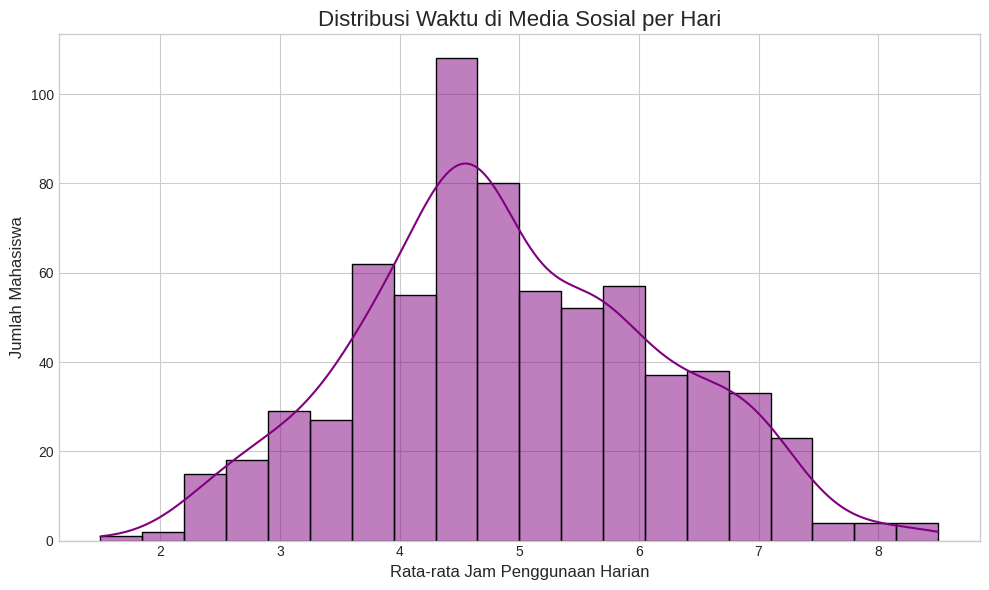

In [5]:
# Langkah 2. EDA
# file_path yang digunakan (usahakan pakai drive dekstop)
file_path = "/content/drive/My Drive/Students_Social_Media_Addiction.csv"

try:
  df = pd.read_csv(file_path)
  print("Dataset Berhasil Dimuat...")
except FileNotFoundError:
  print(f"File tidak ditemukan di path: {file_path}. Pastikan path sudah benar")
  df = None # Hentikan Eksekusi jika file tidak ada

if df is not None:
  # Tampilkan 5 baris data pertama
  print("\n")
  print(df.head())
  # Tampilkan info dasar dataframe
  print("\n")
  print(df.info())
  # Analisis Deskriptif untuk kolom numerik
  print("\n")
  print(df.describe())
  # Visualisasi Data Awal
  plt.style.use('seaborn-v0_8-whitegrid')

  # 1. Distribusi Usia
  plt.figure(figsize=(10, 6))
  sns.histplot(df['Age'], bins=15, kde = True, color='skyblue')
  plt.title('Distribusi Usia Mahasiswa', fontsize = 16)
  plt.xlabel('Usia', fontsize=12)
  plt.ylabel('Frekuensi', fontsize=12)
  plt.show()

  # 2. Waktu Rata-rata di Media Sosial
  # --- PERBAIKAN UNTUK MENGHINDARI KEYERROR DAN MERAPIKAN PLOT ---
  # Secara dinamis mencari nama kolom yang benar untuk 'waktu yang dihabiskan'
  time_spent_col = None
  for col in df.columns:
      # Menggunakan 'time you spend' atau 'usage_hours' sebagai kata kunci
      if 'time you spend' in col.lower() or 'usage_hours' in col.lower():
          time_spent_col = col
          print(f"\nKolom untuk waktu ditemukan: '{time_spent_col}'")
          break

  if time_spent_col:
      # Karena kolom 'Avg_Daily_Usage_Hours' adalah numerik, kita gunakan histplot
      # bukan countplot, untuk hasil yang lebih tepat.
      plt.figure(figsize=(10, 6))
      sns.histplot(df[time_spent_col], bins=20, kde=True, color='purple')

      plt.title('Distribusi Waktu di Media Sosial per Hari', fontsize=16)
      plt.xlabel('Rata-rata Jam Penggunaan Harian', fontsize=12)
      plt.ylabel('Jumlah Mahasiswa', fontsize=12)
      plt.tight_layout()
      plt.show()

  else:
      print("\nPERINGATAN: Tidak dapat menemukan kolom 'time you spend' atau 'usage_hours'. Visualisasi untuk waktu dilewati.")








In [6]:
# Langkah 3: Klasifikasi Tingkat Kecanduan Memakai LLM


llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"max_new_tokens": 10, "temperature": 0.4}
)

def classify_addiction_level(row):
    """
    Fungsi untuk mengklasifikasikan tingkat kecanduan menggunakan model Langchain.
    """
    prompt_template = f"""
    Anda adalah seorang psikolog digital. Berdasarkan data survei mahasiswa berikut, klasifikasikan tingkat potensi kecanduan media sosialnya ke dalam salah satu dari tiga kategori: 'Rendah', 'Sedang', atau 'Tinggi'.

    Data Mahasiswa:
    - Usia: {row['Age']}
    - Gender: {row['Gender']}
    - Waktu di Medsos per hari (jam): {row['Avg_Daily_Usage_Hours']}
    - Jam Tidur per Malam: {row['Sleep_Hours_Per_Night']}
    - Skor Kesehatan Mental (1-10, 10=baik): {row['Mental_Health_Score']}
    - Skor Kecanduan yang dilaporkan (1-10, 10=kecanduan): {row['Addicted_Score']}

    Berdasarkan kombinasi data di atas, berikan HANYA SATU KATA sebagai output klasifikasi: 'Rendah', 'Sedang', atau 'Tinggi'.
    """

    try:
        # Memanggil model dengan llm.invoke()
        output = llm.invoke(prompt_template)
        # --- PERBAIKAN: Menghapus print() yang tidak perlu ---
        classification = output.strip().replace("'", "").replace('"', '').replace(".", "")

        if classification not in ['Rendah', 'Sedang', 'Tinggi']:
            # Jika output tidak sesuai format, coba ambil kata pertama secara diam-diam
            first_word = classification.split()[0].replace("*","")
            if first_word in ['Rendah', 'Sedang', 'Tinggi']:
                return first_word
            return 'Tidak Terklasifikasi' # Tandai sebagai tidak terklasifikasi jika masih gagal
        return classification
    except Exception as e:
        # Hanya print jika terjadi error koneksi atau API
        print(f"Error saat memanggil API Replicate: {e}")
        return "Error"

if df is not None:
    print("\n--- Memulai Proses Klasifikasi dengan  (Langchain) ---")

    print("Menjalankan klasifikasi pada seluruh dataset... Ini akan memakan waktu beberapa menit. Harap tunggu.")
    df_classified = df.copy()
    df_classified['Tingkat_Kecanduan'] = df_classified.apply(classify_addiction_level, axis=1)
    print("Klasifikasi selesai.")

    # Simpan hasil ke file CSV baru
    df_classified.to_csv('/content/drive/My Drive/hasil_klasifikasi_kecanduan_langchain.csv', index=False)
    print("Hasil klasifikasi telah disimpan ke Google Drive.")

    print("\n--- Contoh Hasil Klasifikasi ---")
    print(df_classified[['Age', 'Gender', 'Avg_Daily_Usage_Hours', 'Tingkat_Kecanduan']].head(10))



--- Memulai Proses Klasifikasi dengan  (Langchain) ---
Menjalankan klasifikasi pada seluruh dataset... Ini akan memakan waktu beberapa menit. Harap tunggu.
Klasifikasi selesai.
Hasil klasifikasi telah disimpan ke Google Drive.

--- Contoh Hasil Klasifikasi ---
   Age  Gender  Avg_Daily_Usage_Hours Tingkat_Kecanduan
0   19  Female                    5.2            Tinggi
1   22    Male                    2.1            Rendah
2   20  Female                    6.0            Tinggi
3   18    Male                    3.0            Sedang
4   21    Male                    4.5            Tinggi
5   19  Female                    7.2            Tinggi
6   23    Male                    1.5            Rendah
7   20  Female                    5.8            Tinggi
8   18    Male                    4.0            Sedang
9   21  Female                    3.3            Sedang



--- Menganalisis Hasil Klasifikasi yang Sebenarnya ---

--- Distribusi Tingkat Kecanduan ---
Tingkat_Kecanduan
Tinggi    402
Sedang    272
Rendah     31
Name: count, dtype: int64


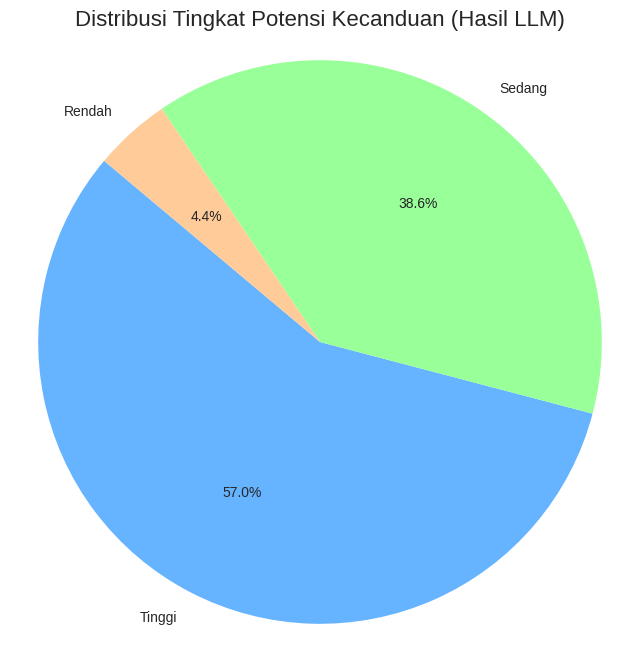


--- Analisis Platform pada Kelompok Kecanduan 'Tinggi' ---
Jumlah pengguna per platform di kelompok 'Tinggi':
Most_Used_Platform
Instagram    151
TikTok       129
WhatsApp      54
Facebook      34
Snapchat      12
Twitter       11
WeChat         8
YouTube        3
Name: count, dtype: int64


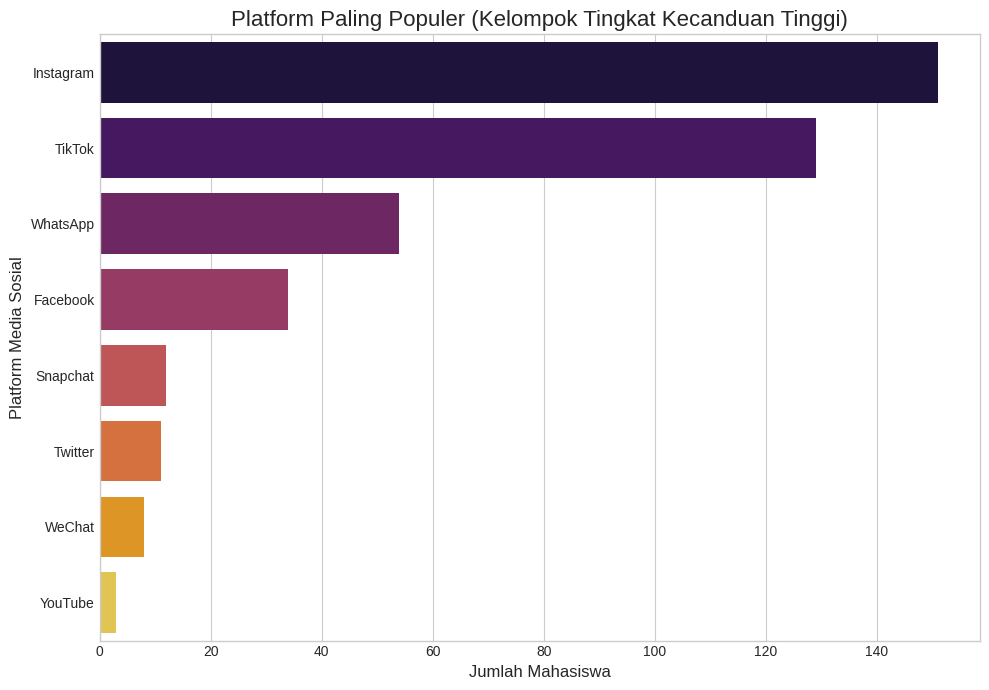


🤖 Analisis AI untuk Grafik Platform:
Dari data tersebut, dapat disimpulkan bahwa mahasiswa dengan tingkat kecanduan tinggi tertentu lebih sering menggunakan platform media sosial seperti Instagram (151 pengguna) dan TikTok (129 pengguna). Ini menunjukkan potensi risiko kecanduan yang lebih besar terhadap platform visual dan video yang memiliki fitur interaktif yang dapat menarik pengguna untuk menghabiskan waktu yang lebih lama. 

Sorotan yang paling mengkhawatirkan adalah dominasi Instagram dan TikTok dalam golongan ini, karena keduanya telah dikaitkan dengan gejala kecanduan yang serius, seperti gangguan tidur, gangguan perhatian, dan rasa kekurangan yang diatasi dengan menggunakan platform tersebut. 

Implikasi praktis bagi mahasiswa ini adalah perlu diberikan perhatian khusus terhadap penggunaan waktu mereka di platform-platform tersebut. Pendidikan dan penjelasan tentang gejala kecanduan media sosial dan cara mengelola waktu digital secara efektif dapat membantu mereka menjaga ga

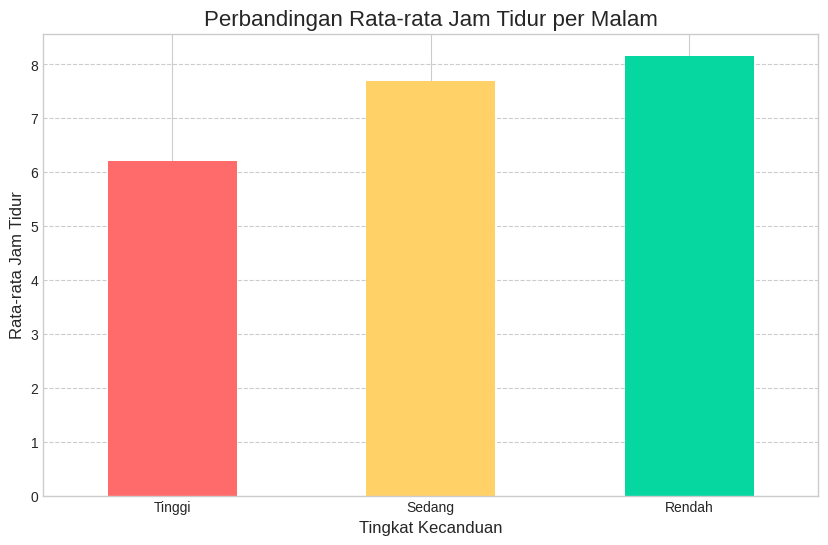


🤖 Analisis AI untuk Grafik Waktu Tidur:
Dari data yang diberikan, terdapat hubungan yang kuat antara tingkat kecanduan media sosial dan jumlah jam tidur malam. Kelompok dengan tingkat kecanduan tinggi (6.209204) memiliki jumlah jam tidur yang paling sedikit, sedangkan kelompok dengan tingkat kecanduan rendah (8.161290) memiliki jumlah jam tidur yang paling banyak. Ini menunjukkan bahwa orang dengan tingkat kecanduan lebih tinggi mungkin mengalami insomnia atau masalah tidur karena terlibat lebih banyak dengan media sosial, yang dapat menyebabkan pola tidur yang tidak sehat.

Sorotan yang paling mengkhawatirkan adalah hubungannya antara kecanduan media sosial yang tinggi dan keterlambatan tidur. Hal ini mengindikasikan bahwa kecanduan media sosial dapat menyebabkan masalah tidur yang parah, yang dapat mempengaruhi kualitas hidup secara keseluruhan, termasuk kinerja akademis dan kesehatan mental.

Implikasi praktis bagi mahasiswa yang terlibat dalam kecanduan media sosial adalah penting

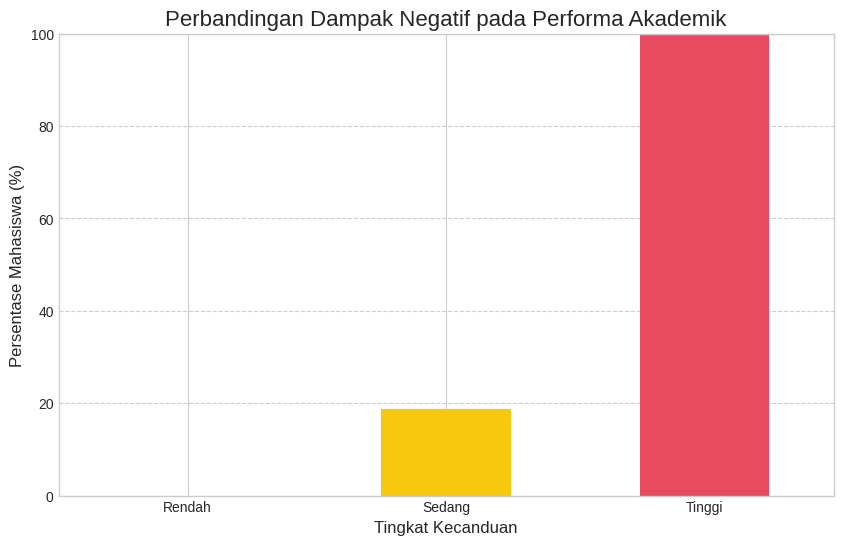


🤖 Analisis AI untuk Grafik Dampak Akademik:
Dari data yang diberikan, terdapat hubungan yang jelas antara tingkat kecanduan media sosial dan pengaruh terhadap performa akademik mahasiswa. Tingkat kecanduan yang tinggi (100%) menunjukkan risiko yang signifikan terhadap gangguan akademik, yang diikuti oleh tingkat sedang (18.75%) yang juga menunjukkan potensi masalah. Penurunan tingkat kecanduan rendah (0%) tidak menunjukkan mahasiswa yang terlibat dalam masalah akademik akibat kecanduan media sosial.

Sorotan yang paling mengkhawatirkan adalah tingkat kecanduan tinggi, dengan persentase penuh, yang sangat menunjukkan bahwa mahasiswa dengan tingkat kecanduan media sosial yang tinggi memiliki risiko yang signifikan untuk mengalami gangguan akademik.

Implikasi praktis bagi mahasiswa yang memiliki tingkat kecanduan tinggi adalah perlu diberikan perhatian khusus terhadap pola penggunaan media sosial mereka. Intervensi dapat termasuk pengembangan keterampilan digital yang sehat, pengelolaan

In [10]:

# ------------------------------------------------------------------------------
# LANGKAH 4: ANALISIS & SUMMARIZATION HASIL KLASIFIKASI
# ------------------------------------------------------------------------------
# Penjelasan: Setelah semua data memiliki label, kita menganalisis hasilnya untuk
# menemukan insight dan membuat ringkasan.

def get_ai_analysis(chart_description, data_summary):
    """Fungsi untuk meminta AI menganalisis data dari sebuah grafik."""
    # --- PERBAIKAN: Prompt dibuat lebih tajam dan fokus pada isu kecanduan ---
    prompt = f"""
    Anda adalah seorang psikolog digital yang menganalisis data untuk memahami masalah kecanduan media sosial.
    Konteks Grafik: {chart_description}
    Data Mentah:
    {data_summary}

    Tugas: Berdasarkan data di atas, berikan analisis tajam (2-3 kalimat) dalam Bahasa Indonesia yang menekankan **isu kecanduan media sosial**.
    - Apa makna dari data ini terkait risiko kecanduan?
    - Sorot temuan yang paling mengkhawatirkan atau signifikan.
    - Jelaskan implikasinya secara praktis bagi mahasiswa.
    """
    try:
        analysis = llm.invoke(prompt)
        return analysis.strip()
    except Exception as e:
        return f"Gagal mendapatkan analisis AI: {e}"

if 'df_classified' in locals() and not df_classified.empty:
    print("\n--- Menganalisis Hasil Klasifikasi yang Sebenarnya ---")

    # 1. Analisis Distribusi Hasil Klasifikasi
    print("\n--- Distribusi Tingkat Kecanduan ---")
    addiction_counts = df_classified['Tingkat_Kecanduan'].value_counts()
    print(addiction_counts)

    plt.figure(figsize=(8, 8))
    valid_counts = addiction_counts[addiction_counts.index.isin(['Rendah', 'Sedang', 'Tinggi', 'Tidak Terklasifikasi', 'Error'])]
    plt.pie(valid_counts, labels=valid_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99', '#ff6666', '#cccccc'])
    plt.title('Distribusi Tingkat Potensi Kecanduan (Hasil LLM)', fontsize=16)
    plt.axis('equal')
    plt.show()

    # --- ANALISIS VISUAL 1: Platform Paling Populer di Kelompok Kecanduan Tinggi ---
    print("\n--- Analisis Platform pada Kelompok Kecanduan 'Tinggi' ---")
    df_tinggi = df_classified[df_classified['Tingkat_Kecanduan'] == 'Tinggi']

    if not df_tinggi.empty:
        platform_counts = df_tinggi['Most_Used_Platform'].value_counts()
        print("Jumlah pengguna per platform di kelompok 'Tinggi':")
        print(platform_counts)

        plt.figure(figsize=(10, 7))
        sns.barplot(x=platform_counts.values, y=platform_counts.index, palette='inferno', hue=platform_counts.index, legend=False)
        plt.title('Platform Paling Populer (Kelompok Tingkat Kecanduan Tinggi)', fontsize=16)
        plt.xlabel('Jumlah Mahasiswa', fontsize=12)
        plt.ylabel('Platform Media Sosial', fontsize=12)
        plt.tight_layout()
        plt.show()

        # --- Analisis Otomatis oleh AI ---
        chart_desc_1 = "Grafik ini menunjukkan platform media sosial yang paling banyak digunakan oleh mahasiswa yang diklasifikasikan memiliki tingkat kecanduan 'Tinggi'."
        ai_analysis_1 = get_ai_analysis(chart_desc_1, platform_counts.to_string())
        print("\n🤖 Analisis AI untuk Grafik Platform:")
        print(ai_analysis_1)
        time.sleep(1)

    # --- ANALISIS VISUAL 2: Perbandingan Waktu Tidur antar Kelompok ---
    print("\n--- Analisis Perbandingan Waktu Tidur antar Kelompok ---")
    sleep_comparison = df_classified.groupby('Tingkat_Kecanduan')['Sleep_Hours_Per_Night'].mean().sort_values()
    print("Rata-rata jam tidur per kelompok:")
    print(sleep_comparison)

    plt.figure(figsize=(10, 6))
    sleep_comparison.plot(kind='bar', color=['#FF6B6B', '#FFD166', '#06D6A0'])
    plt.title('Perbandingan Rata-rata Jam Tidur per Malam', fontsize=16)
    plt.xlabel('Tingkat Kecanduan', fontsize=12)
    plt.ylabel('Rata-rata Jam Tidur', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # --- Analisis Otomatis oleh AI ---
    chart_desc_2 = "Grafik ini membandingkan rata-rata jam tidur per malam antara kelompok dengan tingkat kecanduan yang berbeda."
    ai_analysis_2 = get_ai_analysis(chart_desc_2, sleep_comparison.to_string())
    print("\n🤖 Analisis AI untuk Grafik Waktu Tidur:")
    print(ai_analysis_2)
    time.sleep(1)

    # --- ANALISIS VISUAL 3: Perbandingan Dampak Akademik antar Kelompok ---
    print("\n--- Analisis Perbandingan Dampak Akademik antar Kelompok ---")
    academic_impact = df_classified[df_classified['Affects_Academic_Performance'] == 'Yes']
    impact_comparison = (academic_impact.groupby('Tingkat_Kecanduan').size() / df_classified.groupby('Tingkat_Kecanduan').size() * 100).fillna(0).sort_values()
    print("Persentase performa akademik terganggu per kelompok:")
    print(impact_comparison)

    plt.figure(figsize=(10, 6))
    impact_comparison.plot(kind='bar', color=['#4ECDC4', '#F9C80E', '#E84A5F'])
    plt.title('Perbandingan Dampak Negatif pada Performa Akademik', fontsize=16)
    plt.xlabel('Tingkat Kecanduan', fontsize=12)
    plt.ylabel('Persentase Mahasiswa (%)', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # --- Analisis Otomatis oleh AI ---
    chart_desc_3 = "Grafik ini membandingkan persentase mahasiswa yang merasa performa akademiknya terganggu, dibagi per tingkat kecanduan."
    ai_analysis_3 = get_ai_analysis(chart_desc_3, impact_comparison.to_string())
    print("\n🤖 Analisis AI untuk Grafik Dampak Akademik:")
    print(ai_analysis_3)
    time.sleep(1)

    # --- Summarization Profil (Tetap ada untuk ringkasan naratif) ---
    def summarize_group_profile(group_df, group_name):
        if group_df.empty:
            return f"Tidak ada data untuk kelompok '{group_name}'."

        avg_time_spent = group_df['Avg_Daily_Usage_Hours'].mean()
        most_common_platform = group_df['Most_Used_Platform'].mode()[0]
        avg_sleep = group_df['Sleep_Hours_Per_Night'].mean()
        academic_impact_pct = (group_df['Affects_Academic_Performance'] == 'Yes').mean() * 100

        prompt_template = f"""
        Anda adalah seorang analis data. Berdasarkan statistik dari kelompok mahasiswa yang diklasifikasikan memiliki tingkat kecanduan '{group_name}', buatlah ringkasan profil dalam satu paragraf (3-4 kalimat).

        Statistik Kelompok '{group_name}':
        - Rata-rata waktu di medsos: {avg_time_spent:.1f} jam/hari.
        - Platform paling populer: {most_common_platform}.
        - Rata-rata jam tidur: {avg_sleep:.1f} jam/malam.
        - Persentase performa akademik terganggu: {academic_impact_pct:.0f}%.

        Jelaskan profil khas kelompok ini dalam narasi yang mudah dipahami.
        """
        try:
            summary = llm.invoke(prompt_template)
            return summary.strip()
        except Exception as e:
            return f"Gagal membuat ringkasan: {e}"

    print("\n--- Ringkasan Profil Keseluruhan oleh AI ---")
    for level in ['Rendah', 'Sedang', 'Tinggi']:
        print(f"\n--- Profil Kelompok: {level} ---")

        group_df = df_classified[df_classified['Tingkat_Kecanduan'] == level]

        if not group_df.empty:
            summary = summarize_group_profile(group_df, level) # Menggunakan fungsi lama untuk ringkasan umum
            print(summary)
        else:
            print(f"Tidak ada mahasiswa yang diklasifikasikan sebagai '{level}'.")
        time.sleep(1)

else:
    print("\nAnalisis akhir dilewati karena klasifikasi belum dijalankan.")

print("\n--- Analisis Selesai ---")
